In [263]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [264]:
import numpy as np
import scipy as sp
import sklearn as sk
import cartopy as cp
import xarray as xr
import pandas as pd
import cftime
import dateutil
import dask
#Use the 2 lines below if the notebook has a dark theme (to make labelling visible):
from jupyterthemes import jtplot
jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)
import matplotlib.pyplot as plt
#The following code resets the default plot size so you don't have to fiddle with figsize every time"
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

In [265]:
def covariance(x, y, dims=None):
    return xr.dot(x - x.mean(dims), y - y.mean(dims), dims=dims) / x.count(dims)

def correlation(x, y, dims=None):
    return covariance(x, y, dims) / (x.std(dims) * y.std(dims))

# Load Data

In [266]:
dat = xr.open_dataset('/global/scratch/medhap02/ISMData/ERA5_MSLP_SST_Td_tas_Jan1979toMay2020.grib',engine='pynio')

sst = dat['SSTK_GDS0_SFC_S123']
sst = sst.rename({'g0_lon_2':'lon', 'g0_lat_1':'lat', 'initial_time0_hours':'time'})

slp = dat['MSL_GDS0_SFC_S123']
slp = slp.rename({'g0_lon_2':'lon', 'g0_lat_1':'lat', 'initial_time0_hours':'time'})

print(sst)
print(slp)

<xarray.DataArray 'SSTK_GDS0_SFC_S123' (time: 497, lat: 721, lon: 1440)>
[516005280 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-05-01
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.25 359.5 359.75
Attributes:
    center:                          European Center for Medium-Range Weather...
    long_name:                       Sea surface temperature
    units:                           K
    level_indicator:                 [1]
    gds_grid_type:                   [0]
    parameter_table_version:         [128]
    parameter_number:                [34]
    forecast_time:                   [0]
    forecast_time_units:             hours
    statistical_process_descriptor:  average of N uninitialized analyses
    statistical_process_duration:    instantaneous (beginning at reference ti...
    N:                               [744 672 74

In [267]:
msedat = xr.open_dataset('/global/scratch/medhap02/ISMData/MSE.ERA5.2meter.mon.mean.jan1979june2020.nc')
mse = msedat['__xarray_dataarray_variable__']
mse = mse.rename({'g0_lon_2':'lon', 'g0_lat_1':'lat', 'initial_time0_hours':'time'})

print(mse)

<xarray.DataArray '__xarray_dataarray_variable__' (time: 498, lat: 721, lon: 1440)>
[517043520 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-06-01
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.25 359.5 359.75


In [268]:
airi_dat = xr.open_dataset('/global/scratch/medhap02/ISMData/pALLIN.nc', decode_times=False)
units, reference_date = airi_dat.time.attrs['units'].split('since')
airi_dat['time'] = pd.date_range(start=reference_date, periods=airi_dat.sizes['time'], freq='MS')
precip = airi_dat['precip']

In [269]:
precip_full = precip.sel(time=slice('1979-01-01','2020-12-31'))
precip_full = precip
junes = np.arange(5,1752,12)
julys = np.arange(6,1752,12)
augusts = np.arange(7,1752, 12)
septembers = np.arange(8,1752,12)
precip_june = precip_full[junes]
precip_july = precip_full[julys]
precip_august = precip_full[augusts]
precip_september = precip_full[septembers]

precip_july.time.data = precip_june.time.data
precip_august.time.data = precip_june.time.data
precip_september.time.data = precip_june.time.data

precip_jjas = (precip_june + precip_july + precip_august + precip_september)
precip_jjas = precip_jjas.sel(time=slice('1979-01-01','2020-12-31'))
print(precip_jjas)

<xarray.DataArray 'precip' (time: 38)>
array([707.7    , 882.8    , 852.19995, 735.4    , 955.60004, 836.7    ,
       759.8    , 743.     , 697.1    , 961.5    , 866.60004, 908.6    ,
       816.1    , 814.8    , 846.     , 957.5    , 819.60004, 851.     ,
       854.5    , 859.2001 , 807.8    , 785.80005, 794.49994, 646.80005,
       856.1    , 741.7    , 828.5    , 905.3    , 947.1    , 882.19995,
       702.     , 885.7    , 902.89996, 805.10004, 947.30005, 736.4    ,
       728.10004, 844.9    ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-07-01 1980-07-01 ... 2016-07-01


(2000, 2020)

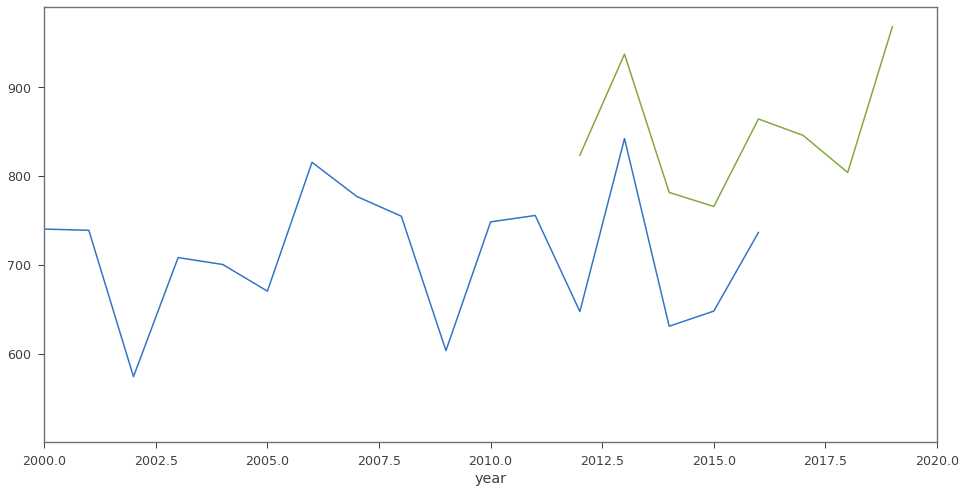

In [270]:
def is_jjas(month):
    return (month >= 6) & (month <= 9)

pIITMJJAS = precip.sel(time=is_jjas(precip['time.month'])).groupby('time.year').sum(dim='time')
pIITMJJAS.mean()

pIMDJJASupdateArray = np.array([823.6, 937.4, 781.7, 765.8, 864.4, 845.9, 804.1, 968.3] )
yearUpdate = np.arange(2012,2020)

# 2012 - 2018 values are from IMD reports obtained from their Hydromet division,
#  Customized Rainfall Information System (CRIS), 
#  http://hydro.imd.gov.in/hydrometweb/(S(gk24v0qwwwzr5hqr335i0q55))/landing.aspx#
#  2019 report not yet available so obtained from news articles citing IMD,
#  https://weather.com/en-IN/india/monsoon/news/2019-09-30-wettest-september-india-records-highest-monsoon-rainfall-25-years
#
pIMDJJASnormals = 886.9
pIMDJJASupdate = xr.DataArray(pIMDJJASupdateArray,coords={'year':yearUpdate},dims=['year'])
#pIMDJJAS = xr.concat([ptmpJJAS,pIMDJJASupdate],dim='year')
pIITMJJAS.plot()
pIMDJJASupdate.plot()
plt.xlim(2000,2020)

# EPT new

In [271]:
#EP-ENSOpredictor
#(30n-30s, 155-175e)
#(10n-10s, 115-80w)

#DSST1
latrange1 = sst.sel(lat = slice(30, -30)).lat
weights1 = np.cos(latrange1*np.pi/180)

marchdata1 = sst.sel(lat = slice(30, -30), lon = slice(155, 175), time = (sst['time.month']==3))
marchSST1 = marchdata1.sel(time = slice('1979-03-01', '2020-03-01'))
marchmean1 = (marchSST1*weights1).mean({'lon', 'lat'})/weights1.mean() - 273.15

maydata1 = sst.sel(lat = slice(30, -30), lon = slice(155, 175), time = (sst['time.month']==5))
maySST1 = maydata1.sel(time = slice('1979-05-01', '2020-05-01'))
maymean1 = (maySST1*weights1).mean({'lon', 'lat'})/weights1.mean() - 273.15

marchmean1.time.data = maymean1.time.data
DSST1 = maymean1 - marchmean1

#DSST2
latrange2 = sst.sel(lat = slice(10, -10)).lat
weights2 = np.cos(latrange2*np.pi/180)

marchdata2 = sst.sel(lat = slice(10, -10), lon = slice(245, 280), time = (sst['time.month']==3))
marchSST2 = marchdata2.sel(time = slice('1979-03-01', '2020-03-01'))
marchmean2 = (marchSST2*weights2).mean({'lon', 'lat'})/weights2.mean() - 273.15

maydata2 = sst.sel(lat = slice(10, -10), lon = slice(245, 280), time = (sst['time.month']==5))
maySST2 = maydata2.sel(time = slice('1979-05-01', '2020-05-01'))
maymean2 = (maySST2*weights2).mean({'lon', 'lat'})/weights2.mean() - 273.15

marchmean2.time.data = maymean2.time.data
DSST2 = (maymean2 - marchmean2)

EPTinitial = DSST1 - DSST2
#print(EPTinitial)
EPTstd = 0.514143
EPTmean = 0.38594
EPTnew = (EPTinitial - EPTmean)/EPTstd

print("EPT mean", EPTmean)
print("EPT std", EPTstd)

EPT mean 0.38594
EPT std 0.514143


In [272]:
print(EPTnew)

<xarray.DataArray (time: 42)>
array([-1.346405, -0.225701,  0.052205, -0.474107, -0.212227,  1.541096,
        0.992645, -0.027214, -0.680785,  1.761961,  0.155247, -0.921356,
       -0.39077 , -1.000181, -0.316813,  0.178752,  0.783948,  1.330797,
       -1.697319,  1.002617,  0.653365,  0.345009,  1.238617,  0.088115,
        1.972141,  1.541749, -0.770769,  0.71189 ,  1.313465, -0.087045,
       -1.280164,  0.56528 , -0.384182, -0.057248,  2.068357, -0.241193,
       -1.563352,  1.673401,  0.739312, -0.87488 , -0.322867, -0.398427],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2020-05-01


# CPT new

In [273]:
#CP-ENSOpredictor
#(55-5s, 175e-155w)

#DSST
latrange1 = sst.sel(lat = slice(-5, -55)).lat
weights1 = np.cos(latrange1*np.pi/180)

aprildata1 = sst.sel(lat = slice(-5, -55), lon = slice(175, 205), time = (sst['time.month']==4))
aprilSST1 = aprildata1.sel(time = slice('1979-04-01', '2020-04-01'))
aprilmean1 = (aprilSST1*weights1).mean({'lon', 'lat'})/weights1.mean() - 273.15

maydata1 = sst.sel(lat = slice(-5, -55), lon = slice(175, 205), time = (sst['time.month']==5))
maySST1 = maydata1.sel(time = slice('1979-05-01', '2020-05-01'))
maymean1 = (maySST1*weights1).mean({'lon', 'lat'})/weights1.mean() - 273.15

aprilmean1.time.data = maymean1.time.data

CPTinitial = maymean1 - aprilmean1
#print(CPTinitial)
CPTstd = 0.152151
CPTmean = -0.931681
CPTnew = (CPTinitial - CPTmean)/CPTstd

print("CPT mean", CPTmean)
print("CPT std", CPTstd)

CPT mean -0.931681
CPT std 0.152151


In [274]:
print(CPTnew)

<xarray.DataArray (time: 42)>
array([-0.551916, -0.933809,  0.059635, -0.570369,  0.013102, -1.127965,
        0.970443, -1.054154, -1.938285, -0.18667 ,  1.743657,  2.248703,
       -1.185129,  0.52236 ,  0.036369,  0.064048,  0.037973, -0.8957  ,
       -1.473555, -0.091397, -0.205725, -0.328677,  1.397265, -1.270172,
       -0.206727,  0.414852, -0.991173,  0.888408,  1.153768,  0.19402 ,
        0.837061,  0.971847,  1.189069, -0.138332, -0.196298,  0.814396,
       -0.594839,  1.020587, -0.913952,  0.891016, -0.15518 ,  0.280467],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2020-05-01


# PSH new

In [287]:
#mega-ENSOpredictor
#(20-45s, 145-80w)
#(15-35n, 170-125w)
#(0-20n, 40-120e)

#NPcalculation
latrange1 = slp.sel(lat = slice(-20, -45)).lat
weights1 = np.cos(latrange1*np.pi/180)

marchdata1 = slp.sel(lat = slice(-20, -45), lon = slice(215, 260), time = (slp['time.month']==3))
marchSLP1 = marchdata1.sel(time=slice('1979-03-01','2020-03-01'))
marchmean1 = ((marchSLP1*weights1).mean({'lon', 'lat'})/weights1.mean())

aprildata1 = slp.sel(lat = slice(-20, -45), lon = slice(215, 260), time = (slp['time.month']==4))
aprilSLP1 = aprildata1.sel(time=slice('1979-04-01','2020-04-01'))
aprilmean1 = ((aprilSLP1*weights1).mean({'lon', 'lat'})/weights1.mean())

maydata1 = slp.sel(lat = slice(-20, -45), lon = slice(215, 260), time = (slp['time.month']==5))
maySLP1 = maydata1.sel(time = slice('1979-05-01', '2020-05-01'))
maymean1 = ((maySLP1*weights1).mean({'lon', 'lat'})/weights1.mean())

marchmean1.time.data = maymean1.time.data
aprilmean1.time.data = maymean1.time.data
NP = ((marchmean1 + aprilmean1 + maymean1)/3)

#SPcalculation
latrange2 = slp.sel(lat = slice(35, 15)).lat
weights2 = np.cos(latrange2*np.pi/180)

marchdata2 = slp.sel(lat = slice(35, 15), lon = slice(190, 235), time = (slp['time.month']==3))
marchSLP2 = marchdata2.sel(time = slice('1979-03-01', '2020-03-01'))
marchmean2 = ((marchSLP2*weights2).mean({'lon', 'lat'})/weights2.mean())

aprildata2 = slp.sel(lat = slice(35, 15), lon = slice(190, 235), time = (slp['time.month']==4))
aprilSLP2 = aprildata2.sel(time = slice('1979-04-01', '2020-04-01'))
aprilmean2 = ((aprilSLP2*weights2).mean({'lon', 'lat'})/weights2.mean())

maydata2 = slp.sel(lat = slice(35, 15), lon = slice(190, 235), time = (slp['time.month']==5))
maySLP2 = maydata2.sel(time = slice('1979-05-01', '2020-05-01'))
maymean2 = ((maySLP2*weights2).mean({'lon', 'lat'})/weights2.mean())

marchmean2.time.data = maymean2.time.data
aprilmean2.time.data = maymean2.time.data
SP = ((marchmean2 + aprilmean2 + maymean2)/3)

NParea = (25*weights1.mean() * 45)
SParea = (20*weights2.mean() * 45)
Pacific = ((NP * NParea) + (SP * SParea))/(NParea + SParea)

#EQindia
latrange3 = slp.sel(lat = slice(20, 0)).lat
weights3 = np.cos(latrange3*np.pi/180)

marchdata3 = slp.sel(lat = slice(20, 0), lon = slice(40, 120), time = (slp['time.month']==3))
marchSLP3 = marchdata3.sel(time = slice('1979-03-01', '2020-03-01'))
marchmean3 = (marchSLP3*weights3).mean({'lon', 'lat'})/weights3.mean()

aprildata3 = slp.sel(lat = slice(20, 0), lon = slice(40, 120), time = (slp['time.month']==4))
aprilSLP3 = aprildata3.sel(time = slice('1979-04-01', '2020-04-01'))
aprilmean3 = (aprilSLP3*weights3).mean({'lon', 'lat'})/weights3.mean()

maydata3 = slp.sel(lat = slice(20, 0), lon = slice(40, 120), time = (slp['time.month']==5))
maySLP3 = maydata3.sel(time = slice('1979-05-01', '2020-05-01'))
maymean3 = (maySLP3*weights3).mean({'lon', 'lat'})/weights3.mean()

marchmean3.time.data = maymean3.time.data
aprilmean3.time.data = maymean3.time.data

EQindia = (marchmean3 + aprilmean3 + maymean3)/3

PSHinitial = Pacific - EQindia
#print(PSHinitial)
PSHstd = 118.435818
PSHmean = 806.662506
PSHnew = (PSHinitial - PSHmean)/PSHstd

print("PSH mean", PSHmean)
print("PSH std", PSHstd)

PSH mean 806.662506
PSH std 118.435818


In [288]:
print(PSHnew)

<xarray.DataArray (time: 42)>
array([-1.121549, -0.285582, -0.729277, -0.755846, -0.341934,  1.039137,
        1.003773, -0.190966, -1.237016,  1.200239,  0.507418,  0.25802 ,
       -0.484953, -1.736675, -1.716623, -0.491365, -0.928216,  0.219708,
       -2.257655,  0.061209,  2.115176,  1.60575 ,  1.24775 ,  0.115594,
       -0.129598,  0.283786, -0.641432,  0.245994,  0.942137,  1.201616,
        0.250277,  1.570817,  1.655869,  0.877512,  0.376005,  0.095081,
       -1.353885, -0.882377,  0.419841,  0.322714, -0.249388, -0.266454])
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2020-05-01


# MSE new

In [289]:
#MSE
#(0-25n, 45-70e)
#(20-40n, 70-90e)
#(45-70n, 95e-150w)

#MSEleft
latrange1 = mse.sel(lat = slice(25, 0)).lat
weights1 = np.cos(latrange1*np.pi/180)

marchdata1 = mse.sel(lat = slice(25, 0), lon = slice(45, 70), time = (mse['time.month']==3))
marchMSE1 = marchdata1.sel(time = slice('1979-03-01', '2020-03-01'))
marchmean1 = (marchMSE1*weights1).mean({'lon', 'lat'})/weights1.mean()

maydata1 = mse.sel(lat = slice(25, 0), lon = slice(45, 70), time = (mse['time.month']==5))
mayMSE1 = maydata1.sel(time = slice('1979-05-01', '2020-05-01'))
maymean1 = (mayMSE1*weights1).mean({'lon', 'lat'})/weights1.mean()

marchmean1.time.data = maymean1.time.data
MSEleft = maymean1 - marchmean1

#MSEright
latrange2 = mse.sel(lat = slice(40, 20)).lat
weights2 = np.cos(latrange2*np.pi/180)

marchdata2 = mse.sel(lat = slice(40, 20), lon = slice(70, 90), time = (mse['time.month']==3))
marchMSE2 = marchdata2.sel(time = slice('1979-03-01', '2020-03-01'))
marchmean2 = ((marchMSE2*weights2).mean({'lon', 'lat'})/weights2.mean())

maydata2 = mse.sel(lat = slice(40, 20), lon = slice(70, 90), time = (mse['time.month']==5))
mayMSE2 = maydata2.sel(time = slice('1979-05-01', '2020-05-01'))
maymean2 = ((mayMSE2*weights2).mean({'lon', 'lat'})/weights2.mean())

marchmean2.time.data = maymean2.time.data
MSEright = maymean2 - marchmean2

#MSERussia
latrange3 = mse.sel(lat = slice(70, 45)).lat
weights3 = np.cos(latrange3*np.pi/180)

marchdata3 = mse.sel(lat = slice(70, 45), lon = slice(95, 210), time = (mse['time.month']==3))
marchMSE3 = marchdata3.sel(time = slice('1979-03-01', '2020-03-01'))
marchmean3 = (marchMSE3*weights3).mean({'lon', 'lat'})/weights3.mean()

maydata3 = mse.sel(lat = slice(70, 45), lon = slice(95, 210), time = (mse['time.month']==5))
mayMSE3 = maydata3.sel(time = slice('1979-05-01', '2020-05-01'))
maymean3 = (mayMSE3*weights3).mean({'lon', 'lat'})/weights3.mean()

marchmean3.time.data = maymean3.time.data
MSErussia = maymean3 - marchmean3

Leftarea = (25*weights1.mean() * 25)
Rightarea = (20*weights2.mean() * 20)
Russiaarea = (25*weights2.mean() * 15)
MSEinitial = ((MSEleft * Leftarea) + (MSEright * Rightarea) + (MSErussia * Russiaarea))/(Leftarea + Rightarea + Russiaarea)
#print(MSEinitial)
MSEstd = 1370.256777
MSEmean = 13267.877327
MSEnew = (MSEinitial - MSEmean)/MSEstd

print("MSE mean", MSEmean)
print("MSE std", MSEstd)

MSE mean 13267.877327
MSE std 1370.256777


In [290]:
print(MSEnew)

<xarray.DataArray (time: 42)>
array([ 0.39883 ,  1.074523, -0.079938,  0.036887,  1.92259 ,  0.252343,
       -0.229864,  0.245561, -0.832116,  1.018707, -0.554768,  1.859153,
       -0.096234,  0.849083,  1.475249,  0.431017,  0.136228, -1.058076,
       -1.043231,  1.142919,  1.503188,  3.392987,  1.883472,  0.26699 ,
       -0.928543,  0.154919, -0.933621,  1.623472,  1.512637,  1.172932,
        0.344955,  1.019838,  1.566384,  2.180318,  0.511519,  0.058975,
        0.559988, -0.765825,  0.43679 ,  0.101938,  0.430678,  0.770013])
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2020-05-01


# Model

In [298]:
AIRI = 0.357*EPTnew + 0.290*CPTnew + 0.137*PSHnew + 0.162*MSEnew
AIRI

<xarray.DataArray (time: 42)>
array([-0.729764, -0.216432, -0.07693 , -0.432238,  0.192649,  0.406303,
        0.736082, -0.301801, -1.109417,  0.904349,  0.540728,  0.659731,
       -0.565221, -0.305953, -0.098742,  0.084896,  0.185785,  0.074033,
       -1.511576,  0.524967,  0.706887,  0.797504,  1.323457, -0.277804,
        0.475924,  0.734687, -0.801728,  0.808487,  1.17762 ,  0.379827,
       -0.1241  ,  0.864056,  0.688285,  0.412877,  0.815856,  0.172649,
       -0.825384,  0.648425,  0.127167,  0.006788, -0.124662,  0.027335])
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2020-05-01

In [299]:
rainfallmean = precip_jjas.mean()
rainfallstd = precip_jjas.std()

final = (AIRI * rainfallstd) + rainfallmean
print(final)

<xarray.DataArray (time: 42)>
array([769.878995, 810.945875, 822.106146, 793.68125 , 843.672607, 860.765021,
       887.147526, 804.116282, 739.506551, 900.609008, 871.519098, 881.03946 ,
       783.042546, 803.784122, 820.361122, 835.052302, 843.123483, 834.183256,
       707.333583, 870.258263, 884.811908, 892.061325, 934.137932, 806.036067,
       866.334791, 887.035956, 764.121879, 892.939973, 922.47084 , 858.646967,
       818.332467, 897.385573, 883.323803, 861.290959, 893.52952 , 842.072591,
       762.229325, 880.134943, 838.433958, 828.803621, 818.287523, 830.447369])
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2020-05-01


In [300]:
finalforcorr = final.sel(time=slice('1979-01-01','2016-12-31'))
precip_jjas.time.data = finalforcorr.time.data
finalcorrelation = correlation(finalforcorr, precip_jjas, dims='time')
print("multiple linear regression")
print("correlation between final and precipitation", finalcorrelation.data)

multiple linear regression
correlation between final and precipitation 0.44016694179712706


In [301]:
modelyears = []
for x in range(42):
    modelyears.append(x+1979)
modelyears2 = []
for x in range(38):
    modelyears2.append(x+1979)

# Final Information and Graphics

Text(1978, 650, 'r(prediction,obs) = 0.44')

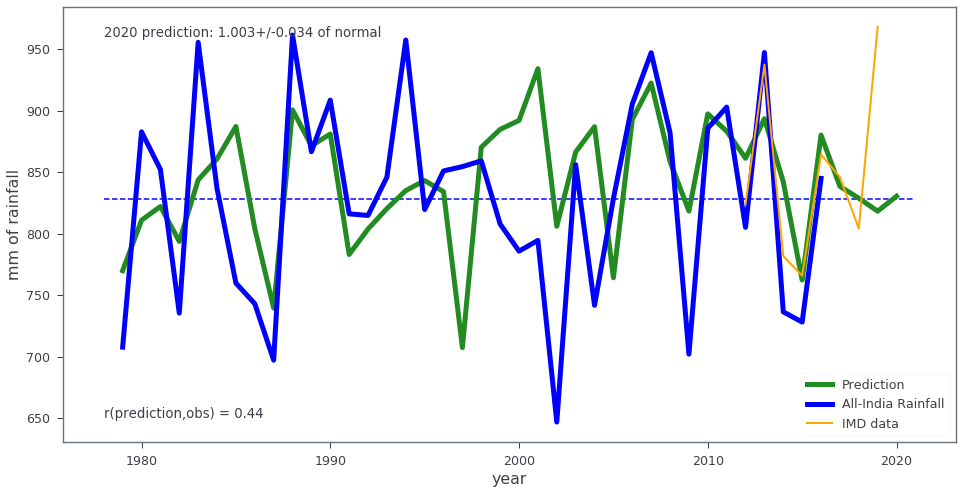

In [302]:
#print("2020 prediction", final.sel(time = slice('2020-05-01', '2020-05-01')))
plt.figure(figsize=(16,8))
plt.title('1979 - 2020 predictions', fontsize = 'xx-large')
plt.plot(modelyears, final, label = 'Prediction', color = 'forestgreen',linewidth=5)
plt.plot(modelyears2, precip_jjas, label = 'All-India Rainfall', color = 'blue',linewidth=5)
#pIITMJJAS.sel(year=slice('1979','2020')).plot(linewidth=2,color='magenta',label='IITM data')
pIMDJJASupdate.sel(year=slice('1979','2020')).plot(linewidth=2,color='orange',label='IMD data')
plt.hlines(rainfallmean,1978,2021,linestyles='dashed',colors='blue')

plt.xlabel('year', fontsize = 'large')
plt.ylabel('mm of rainfall', fontsize = 'large')
plt.legend(loc='lower right')
plt.text(1978,960,predictiontxt)
plt.text(1978,650,correlationtxt)

In [303]:
rmse = 27.929032
print("Root Mean Square Error", rmse)
print("Rainfall Standard Deviation for Training Period", rainfallstd)
print("Rainfall Mean for Training Period", rainfallmean)
airivalue = AIRI.sel(time = slice('2020-05-01', '2020-05-01')).data
print("Prediction's Standard Deviation Above or Below the Mean", airivalue)
prediction2020 = final.sel(time = slice('2020-05-01', '2020-05-01')).data
print("2020 Prediction", prediction2020)
print("Correlation between Model and Rainfall", finalcorrelation)

print()
prediction = (prediction2020[0]/rainfallmean)
bounds = (rmse/rainfallmean)
predictiontxt = ('2020 prediction: '+"{:0.3f}".format(prediction.data)+ "+/-"+ "{:0.3f}".format(bounds.data)+ " of normal")
print(predictiontxt)
correlationtxt = ('r(prediction,obs) = '+"{:0.2f}".format(finalcorrelation.data))
print(correlationtxt)

Root Mean Square Error 27.929032
Rainfall Standard Deviation for Training Period <xarray.DataArray 'precip' ()>
array(80.000595, dtype=float32)
Rainfall Mean for Training Period <xarray.DataArray 'precip' ()>
array(828.26056, dtype=float32)
Prediction's Standard Deviation Above or Below the Mean [0.02733493]
2020 Prediction [830.4473694]
Correlation between Model and Rainfall <xarray.DataArray ()>
array(0.440167)

2020 prediction: 1.003+/-0.034 of normal
r(prediction,obs) = 0.44


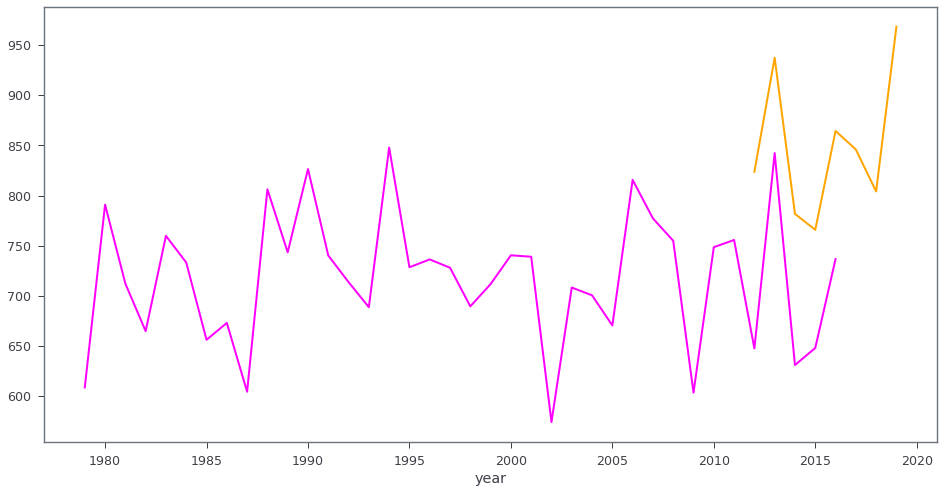

In [228]:
IMDmean = 886.9
#(pIMDJJASupdate/IMDmean).sel(year=slice('1979','2020')).plot(color='orange',marker='.',label='IMD AIRI')
pIITMJJAS.sel(year=slice('1979','2020')).plot(linewidth=2,color='magenta',label='IITM data')
pIMDJJASupdate.sel(year=slice('1979','2020')).plot(linewidth=2,color='orange',label='IMD data')

# not correct

In [143]:
plt.figure(figsize=(10,5))
plt.fill_between(modelyears,(final+rmse)/rainfallmean,(final-rmse)/rainfallmean,color='blue',alpha=0.3)
plt.plot(modelyears, final/rainfallmean, label = 'prediction', color = 'blue',marker='.')
#plt.plot(modelyears2, observedrainfall/, label = 'All-India Rainfall', color = 'blue',linewidth=5)
IITMmean = pIITMJJAS.sel(year=slice(1951,2000)).mean()
IMDmean = 886.9  # from the IMD 2013 monsoon report for 1951-2000 normals, JJAS
(pIITMJJAS/IITMmean).sel(year=slice('1979','2020')).plot(color='magenta',marker='.',label='IITM AIRI')
(pIMDJJASupdate/IMDmean).sel(year=slice('1979','2020')).plot(color='orange',marker='.',label='IMD AIRI')
plt.xlabel('year', fontsize = 'large')
plt.ylabel('fraction of normal', fontsize = 'large')
plt.legend(loc='lower right')
plt.hlines(1.0,1978,2021,linestyles='dashed',color='blue')
plt.xlim((1978,2021))
plt.title('All-India Rainfall predictions and observations, JJAS')
plt.text(1980,0.77,'r(prediction,obs) = '+"{:0.2f}".format(correlation))
plt.text(1980,1.22,'2020 prediction: '+"{:0.2f}".format(prediction2020[0]/rainfallmean) + "+/-" + "{:0.2f}".format(rmse/rainfallmean)+" of normal")
plt.savefig('AIRI_forecast2020_WangEtAl2015model.pdf')

NameError: name 'modelyears' is not defined

<Figure size 720x360 with 0 Axes>

In [207]:
print(precip_jjas)

<xarray.DataArray 'precip' (time: 38)>
array([608.7    , 790.9    , 712.2    , 664.8    , 759.80005, 733.2    ,
       656.19995, 673.     , 604.4    , 806.2    , 743.4    , 826.4    ,
       740.2    , 713.69995, 688.69995, 847.80005, 728.5    , 736.3    ,
       728.     , 689.5    , 711.7    , 740.4    , 739.     , 574.2    ,
       708.3    , 700.5    , 670.5    , 815.6    , 777.2    , 754.9    ,
       603.5    , 748.5    , 755.69995, 647.5    , 842.3    , 631.     ,
       648.     , 736.6    ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2016-05-01


In [44]:
# Copyright (c) 2020 Medha Palavalli.